# Query Performance Comparison Across Datasets

This notebook compares query performance between different methods across all available datasets. It focuses on:
- Comparing query execution times between standard and cached queries
- Analyzing performance by dataset and operation type
- Visualizing performance differences with clear and concise plots

In [97]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [12, 8]
outFolder = "output_with_allocation"
groundTruthFolder = "output_no_allocation"
# Define the methods to compare
METHODS = [
    {
        "name": "Standard Queries",
        "path": f"../{groundTruthFolder}/timeQueries/",
        "method": "m4",
        "database": "influx"
    },
    {
        "name": "Cached Queries",
        "path": f"../{outFolder}/timeCacheQueries/",
        "method": "m4Inf",
        "database": "influx"
    },
    {
        "name": "Cached Queries Non-Aligned",
        "path": f"../{outFolder}/timeMinMaxCacheQueries/",
        "method": "minmax",
        "database": "influx"
    },
]

# Generate a color palette for methods
METHOD_COLORS = sns.color_palette("hls", len(METHODS))

## Load Query Results Data

Load experiment results from all available datasets.

In [98]:
def load_results(base_path, method, database_type, table_name):
    """
    Load results from multiple experiment runs into a single dataframe
    
    Parameters:
    -----------
    base_path : str
        Base path to the queries directory
    method : str    
        Name of the method used (e.g., m4Inf, m4)
    database_type : str
        Type of database (influx, postgres, etc.)
    table_name : str
        Name of the database table
        
    Returns:
    --------
    pd.DataFrame or None: Combined results from all runs
    """
    path_pattern = os.path.join(base_path, method, database_type, table_name, "run_*", "results.csv")
    csv_files = glob.glob(path_pattern)
    
    if not csv_files:
        return None
    
    dfs = []
    for csv_file in csv_files:
        run_name = os.path.basename(os.path.dirname(csv_file))
        df = pd.read_csv(csv_file)
        df['run'] = run_name
        df['dataset'] = table_name
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert date columns to datetime if they exist
    date_columns = ['from', 'to']
    for col in date_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
            
    # Add duration column
    if 'from' in combined_df.columns and 'to' in combined_df.columns:
        combined_df['duration_sec'] = (combined_df['to'] - combined_df['from']).dt.total_seconds()
    
    return combined_df

# Operation type mapping for better readability
def get_operation_type_mapping():
    return {
        'P': 'Pan',
        'ZI': 'Zoom In',
        'ZO': 'Zoom Out',
        'R': 'Resize',
        'MC': 'Measure Change',
        'PD': 'Pattern Detection',
        'NaN': 'Initial Query'
    }

## Find All Available Datasets and Load Data

In [99]:
# First, find all available datasets by looking at directories
def find_datasets(method_info):
    base_path = method_info["path"]
    method = method_info["method"]
    database = method_info["database"]
    
    # Find all dataset directories
    dataset_pattern = os.path.join(base_path, method, database, "*")
    datasets = []
    
    for dataset_dir in glob.glob(dataset_pattern):
        if os.path.isdir(dataset_dir):
            dataset_name = os.path.basename(dataset_dir)
            datasets.append(dataset_name)
    
    return datasets

# Get unique datasets from all methods
all_datasets = set()
for method in METHODS:
    datasets = find_datasets(method)
    all_datasets.update(datasets)

all_datasets = sorted(list(all_datasets))
print(f"Found {len(all_datasets)} datasets: {all_datasets}")

# Load data for each method and dataset
results_by_dataset = {}
all_results = []

for dataset in all_datasets:
    print(f"\nLoading data for dataset: {dataset}")
    dataset_results = []
    
    for i, method in enumerate(METHODS):
        print(f"  Loading {method['name']}...")
        
        df = load_results(
            base_path=method['path'],
            method=method['method'],
            database_type=method['database'],
            table_name=dataset
        )
        
        if df is not None and not df.empty:
            # Add method name and color index
            df['method'] = method['name']
            df['method_idx'] = i
            
            # Add readable operation type
            op_type_map = get_operation_type_mapping()
            df['operation'] = df.apply(
                lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
                axis=1
            )
            
            dataset_results.append(df)
            all_results.append(df)
            print(f"    Loaded {len(df)} queries")
        else:
            print(f"    No data found")
    
    if dataset_results:
        results_by_dataset[dataset] = pd.concat(dataset_results, ignore_index=True)

# Combine all results into a single dataframe for overall analysis
if all_results:
    all_combined = pd.concat(all_results, ignore_index=True)
    print(f"\nLoaded a total of {len(all_combined)} queries across {len(all_datasets)} datasets")
else:
    all_combined = None
    print("\nNo data was loaded.")

Found 2 datasets: ['intel_lab_exp', 'soccer_exp']

Loading data for dataset: intel_lab_exp
  Loading Standard Queries...
    Loaded 51 queries
  Loading Cached Queries...
    Loaded 51 queries
  Loading Cached Queries Non-Aligned...
    Loaded 51 queries

Loading data for dataset: soccer_exp
  Loading Standard Queries...
    Loaded 51 queries
  Loading Cached Queries...
    Loaded 51 queries
  Loading Cached Queries Non-Aligned...
    Loaded 51 queries

Loaded a total of 306 queries across 2 datasets


## Performance Comparison by Dataset

Let's compare the performance across all datasets.

Summary of Query Times by Dataset and Method:


,dataset,method,count,mean,median,min,max
0,intel_lab_exp,Cached Queries,51,0.176275,0.035976,0.011730,7.240554
1,intel_lab_exp,Cached Queries Non-Aligned,51,0.316081,0.040257,0.019912,5.202895
2,intel_lab_exp,Standard Queries,51,1.808138,1.511659,0.859253,4.907403
3,soccer_exp,Cached Queries,51,0.500012,0.023021,0.006330,17.219380
4,soccer_exp,Cached Queries Non-Aligned,51,0.863452,0.034434,0.009884,13.229312
5,soccer_exp,Standard Queries,51,2.555399,2.246140,0.437313,8.397015



Performance Improvement Summary:


,Dataset,Baseline,Compared Method,Baseline Avg (sec),Method Avg (sec),Improvement %,Status
0,intel_lab_exp,Standard Queries,Cached Queries,1.808138,0.176275,90.251039,Faster
1,intel_lab_exp,Standard Queries,Cached Queries Non-Aligned,1.808138,0.316081,82.518991,Faster
2,soccer_exp,Standard Queries,Cached Queries,2.555399,0.500012,80.433110,Faster
3,soccer_exp,Standard Queries,Cached Queries Non-Aligned,2.555399,0.863452,66.210684,Faster


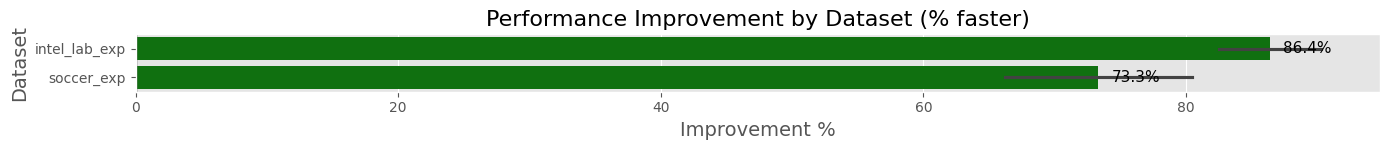

In [100]:
if all_combined is not None:
    # Create a summary table of performance by dataset and method
    dataset_summary = all_combined.groupby(['dataset', 'method'])['Time (sec)'].agg([
        'count', 'mean', 'median', 'min', 'max'
    ]).reset_index()
    
    # Display summary table
    print("Summary of Query Times by Dataset and Method:")
    pd.set_option('display.max_rows', None)
    display(dataset_summary)
    
    # Calculate improvement percentages
    improvement_data = []
    
    for dataset in all_datasets:
        dataset_data = dataset_summary[dataset_summary['dataset'] == dataset]
        
        if len(dataset_data) >= 2:  # Need at least two methods for comparison
            methods = dataset_data['method'].unique()
            if len(methods) >= 2:
                baseline_method = METHODS[0]['name']
                baseline_avg = dataset_data[dataset_data['method'] == baseline_method]['mean'].values[0]
                
                for method in methods:
                    if method != baseline_method:
                        method_avg = dataset_data[dataset_data['method'] == method]['mean'].values[0]
                        imp_pct = ((baseline_avg - method_avg) / baseline_avg) * 100
                        
                        improvement_data.append({
                            'Dataset': dataset,
                            'Baseline': baseline_method,
                            'Compared Method': method,
                            'Baseline Avg (sec)': baseline_avg,
                            'Method Avg (sec)': method_avg,
                            'Improvement %': imp_pct,
                            'Status': 'Faster' if imp_pct > 0 else 'Slower'
                        })
    
    # Display improvement percentages
    if improvement_data:
        improvements_df = pd.DataFrame(improvement_data)
        print("\nPerformance Improvement Summary:")
        display(improvements_df.sort_values('Improvement %', ascending=False))
        
        # Plot improvement percentages by dataset
        plt.figure(figsize=(14, len(all_datasets) * 0.8))
        
        # Get datasets sorted by improvement percentage
        sorted_datasets = improvements_df.sort_values('Improvement %')['Dataset'].values
        
        # Create bar chart of improvement percentages
        ax = sns.barplot(x='Improvement %', y='Dataset', data=improvements_df, 
                   palette=['green' if x > 0 else 'red' for x in improvements_df['Improvement %']])
        
        plt.title('Performance Improvement by Dataset (% faster)', fontsize=16)
        plt.xlabel('Improvement %', fontsize=14)
        plt.ylabel('Dataset', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
        plt.grid(True, axis='x')
        
        # Add percentage labels
        for i, p in enumerate(ax.patches):
            width = p.get_width()
            label_x_pos = width + 1 if width > 0 else width - 5
            ax.text(label_x_pos, p.get_y() + p.get_height()/2, 
                   f'{width:.1f}%', 
                   va='center', fontsize=11)
        
        plt.tight_layout()
        plt.show()
else:
    print("No data available for comparison.")

## Performance Comparison by Operation Type

Let's break down the performance by operation type for each dataset.

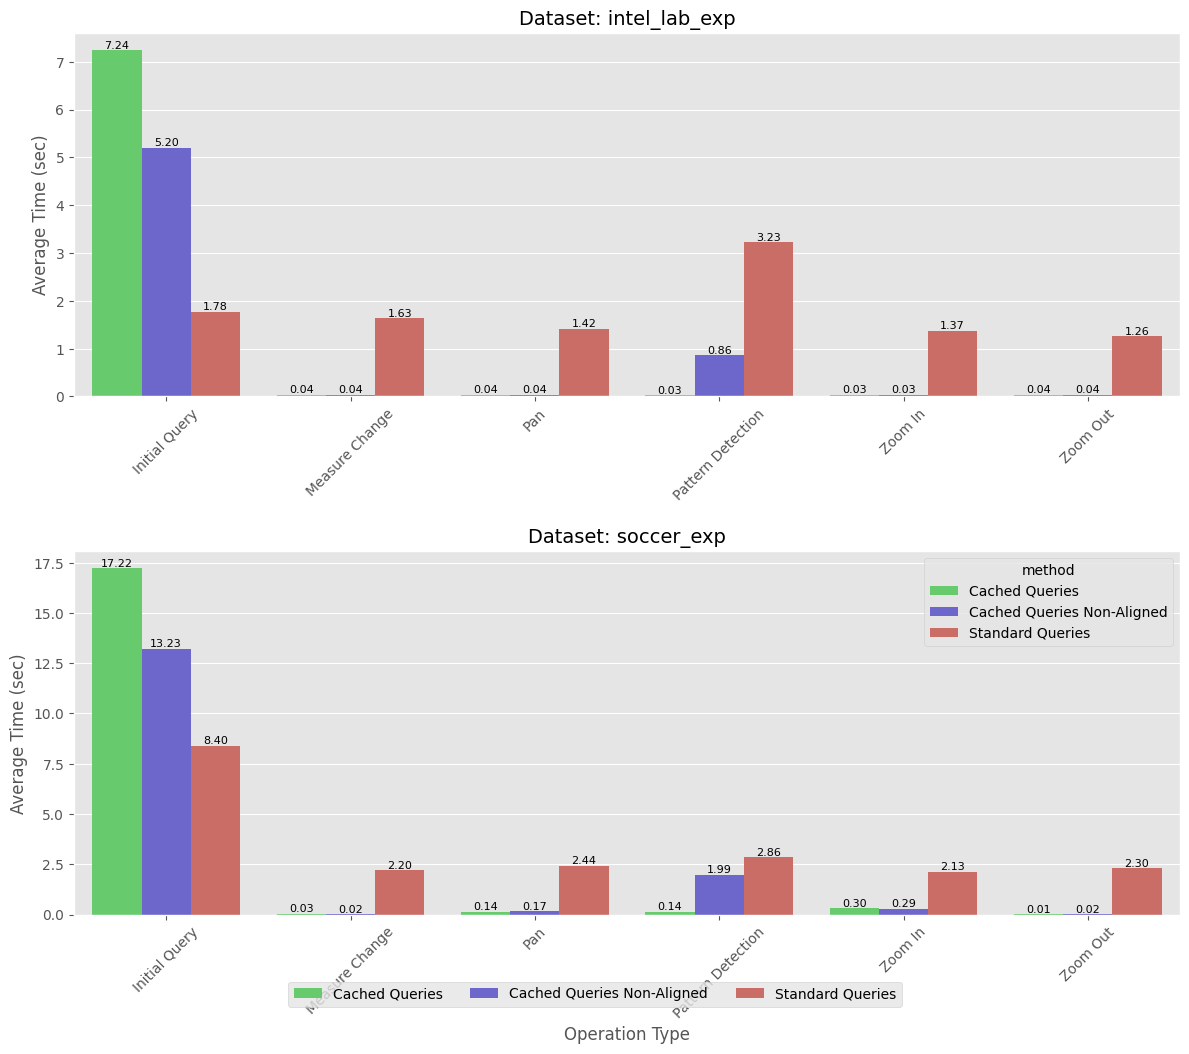



### Performance Breakdown for Dataset: intel_lab_exp


mean                                              \
method            Cached Queries Cached Queries Non-Aligned Standard Queries   
operation                                                                      
Initial Query           7.240554                   5.202895         1.776131   
Measure Change          0.040959                   0.040756         1.630729   
Pan                     0.038761                   0.039611         1.418713   
Pattern Detection       0.026904                   0.857536         3.226743   
Zoom In                 0.032319                   0.033171         1.370244   
Zoom Out                0.039696                   0.040417         1.256518   

                           count                                              \
method            Cached Queries Cached Queries Non-Aligned Standard Queries   
operation                                                                      
Initial Query                  1                          1                1   
Measure Change                 2                          2                2   
Pan                           25                         25               25   
Pattern Detection             11                         11               11   
Zoom In                       10                         10               10   
Zoom Out                       2                          2                2   

                          median                                              
method            Cached Queries Cached Queries Non-Aligned Standard Queries  
operation                                                                     
Initial Query           7.240554                   5.202895         1.776131  
Measure Change          0.040959                   0.040756         1.630729  
Pan                     0.038807                   0.039672         1.350370  
Pattern Detection       0.025934                   0.809340         3.323454  
Zoom In                 0.033614                   0.034531         1.402578  
Zoom Out                0.039696                   0.040417         1.256518


Operation Improvements (Standard Queries vs Cached Queries):


,operation,mean_baseline,mean_comparison,improvement_pct,count_baseline,count_comparison
3,Pattern Detection,3.226743,0.026904,99.166222,11,11
4,Zoom In,1.370244,0.032319,97.641368,10,10
1,Measure Change,1.630729,0.040959,97.488275,2,2
2,Pan,1.418713,0.038761,97.267909,25,25
5,Zoom Out,1.256518,0.039696,96.840825,2,2
0,Initial Query,1.776131,7.240554,-307.658753,1,1



Statistical Significance Tests:
Pattern Detection: p-value = 0.0000, Significant
Zoom In: p-value = 0.0000, Significant
Measure Change: p-value = 0.0004, Significant
Pan: p-value = 0.0000, Significant
Zoom Out: p-value = 0.0757, Not significant


### Performance Breakdown for Dataset: soccer_exp


mean                                              \
method            Cached Queries Cached Queries Non-Aligned Standard Queries   
operation                                                                      
Initial Query          17.219380                  13.229312         8.397015   
Measure Change          0.030110                   0.020971         2.203314   
Pan                     0.139092                   0.168737         2.437863   
Pattern Detection       0.144023                   1.990533         2.859385   
Zoom In                 0.303282                   0.287679         2.134051   
Zoom Out                0.012754                   0.020377         2.298032   

                           count                                              \
method            Cached Queries Cached Queries Non-Aligned Standard Queries   
operation                                                                      
Initial Query                  1                          1                1   
Measure Change                 1                          1                1   
Pan                           18                         18               18   
Pattern Detection             12                         12               12   
Zoom In                       13                         13               13   
Zoom Out                       6                          6                6   

                          median                                              
method            Cached Queries Cached Queries Non-Aligned Standard Queries  
operation                                                                     
Initial Query          17.219380                  13.229312         8.397015  
Measure Change          0.030110                   0.020971         2.203314  
Pan                     0.020916                   0.021898         2.140423  
Pattern Detection       0.012743                   1.803012         2.592455  
Zoom In                 0.026429                   0.030762         1.461535  
Zoom Out                0.010815                   0.014144         2.246242


Operation Improvements (Standard Queries vs Cached Queries):


,operation,mean_baseline,mean_comparison,improvement_pct,count_baseline,count_comparison
5,Zoom Out,2.298032,0.012754,99.445025,6,6
1,Measure Change,2.203314,0.030110,98.633409,1,1
3,Pattern Detection,2.859385,0.144023,94.963132,12,12
2,Pan,2.437863,0.139092,94.294516,18,18
4,Zoom In,2.134051,0.303282,85.788430,13,13
0,Initial Query,8.397015,17.219380,-105.065494,1,1



Statistical Significance Tests:
Zoom Out: p-value = 0.0000, Significant
Pattern Detection: p-value = 0.0001, Significant
Pan: p-value = 0.0000, Significant
Zoom In: p-value = 0.0004, Significant


In [101]:
if all_combined is not None:
    # Get unique operations across all datasets
    all_ops = sorted(all_combined['operation'].unique())
    
    # Create a figure with subplots - one per dataset
    n_datasets = len(all_datasets)
    fig, axes = plt.subplots(n_datasets, 1, figsize=(12, 5 * n_datasets))
    
    # Make sure axes is always a list even with one dataset
    if n_datasets == 1:
        axes = [axes]
    
    for i, dataset in enumerate(all_datasets):
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            
            # Group data by operation type and method
            op_perf = dataset_df.groupby(['operation', 'method'])['Time (sec)'].mean().reset_index()
            
            # Plot on the corresponding subplot
            ax = axes[i]
            sns.barplot(x='operation', y='Time (sec)', hue='method', data=op_perf, ax=ax,
                       palette={m['name']: METHOD_COLORS[i] for i, m in enumerate(METHODS)})
            
            ax.set_title(f'Dataset: {dataset}', fontsize=14)
            ax.set_xlabel('Operation Type' if i == n_datasets-1 else '')
            ax.set_ylabel('Average Time (sec)')
            ax.tick_params(axis='x', rotation=45)
            
            # Add value labels on top of bars
            for c in ax.containers:
                ax.bar_label(c, fmt='%.2f', fontsize=8)
            
            if i < n_datasets - 1:
                ax.legend().set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=len(METHODS))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.show()
    
    # Create detailed operation comparison tables for each dataset
    for dataset in all_datasets:
        if dataset in results_by_dataset:
            print(f"\n\n### Performance Breakdown for Dataset: {dataset}")
            
            dataset_df = results_by_dataset[dataset]
            
            # Detailed operation type comparison
            op_stats = dataset_df.pivot_table(
                index='operation',
                columns='method',
                values='Time (sec)',
                aggfunc=['mean', 'count', 'median']
            )
            
            display(op_stats)
            
            # Calculate improvements for this dataset by operation
            if len(dataset_df['method'].unique()) >= 2:
                baseline_method = METHODS[0]['name']
                comparison_method = METHODS[1]['name']
                
                # Get data for comparison
                baseline_data = dataset_df[dataset_df['method'] == baseline_method]
                comparison_data = dataset_df[dataset_df['method'] == comparison_method]
                
                # Group by operation and calculate stats
                ops_baseline = baseline_data.groupby('operation')['Time (sec)'].agg(['mean', 'count']).reset_index()
                ops_comparison = comparison_data.groupby('operation')['Time (sec)'].agg(['mean', 'count']).reset_index()
                
                # Merge the data
                ops_merged = pd.merge(ops_baseline, ops_comparison, on='operation', suffixes=('_baseline', '_comparison'))
                
                # Calculate improvement percentage
                ops_merged['improvement_pct'] = ((ops_merged['mean_baseline'] - ops_merged['mean_comparison']) / 
                                              ops_merged['mean_baseline']) * 100
                
                # Sort by improvement percentage
                ops_merged = ops_merged.sort_values('improvement_pct', ascending=False)
                
                # Display the results
                print(f"\nOperation Improvements ({baseline_method} vs {comparison_method}):")
                display(ops_merged[['operation', 'mean_baseline', 'mean_comparison', 
                                  'improvement_pct', 'count_baseline', 'count_comparison']])
                
                # Perform statistical tests for significant differences
                print("\nStatistical Significance Tests:")
                for op in ops_merged['operation'].unique():
                    baseline_times = baseline_data[baseline_data['operation'] == op]['Time (sec)']
                    comparison_times = comparison_data[comparison_data['operation'] == op]['Time (sec)']
                    
                    if len(baseline_times) >= 2 and len(comparison_times) >= 2:
                        t_stat, p_value = stats.ttest_ind(baseline_times, comparison_times, equal_var=False)
                        
                        print(f"{op}: p-value = {p_value:.4f}, " + 
                              f"{'Significant' if p_value < 0.05 else 'Not significant'}")
else:
    print("No data available for comparison.")

## Query Execution Time Evolution

Let's visualize how query times evolve across the sequence of operations, highlighting pattern detection queries.

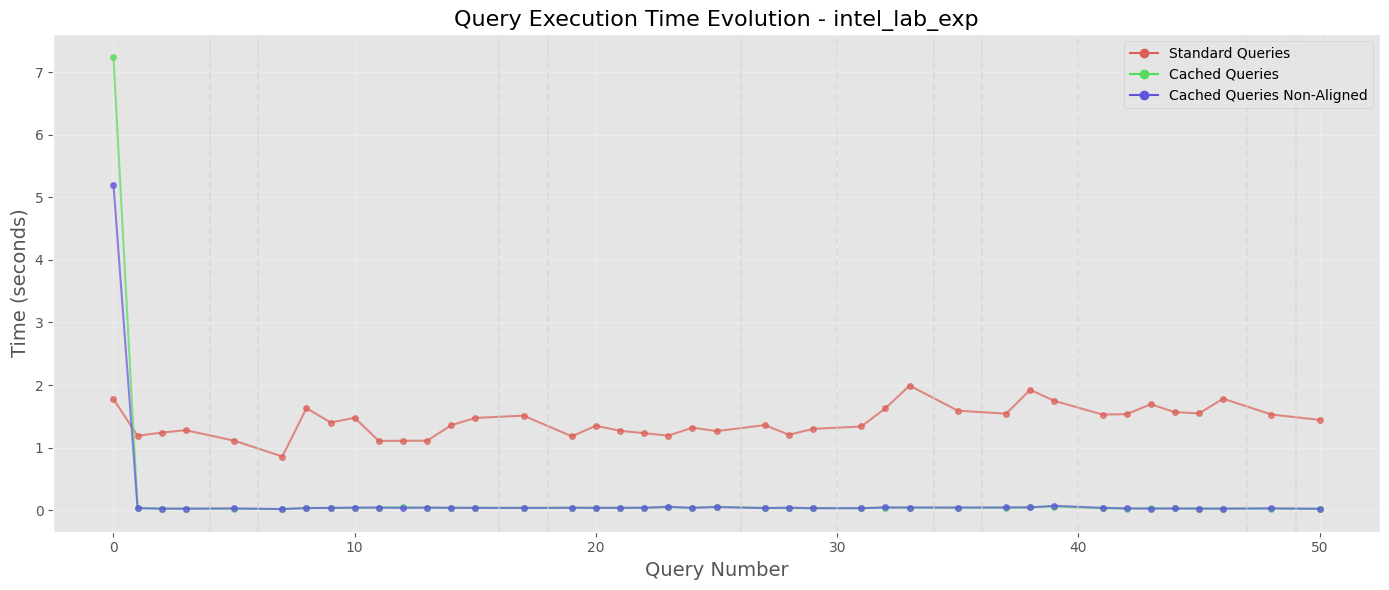

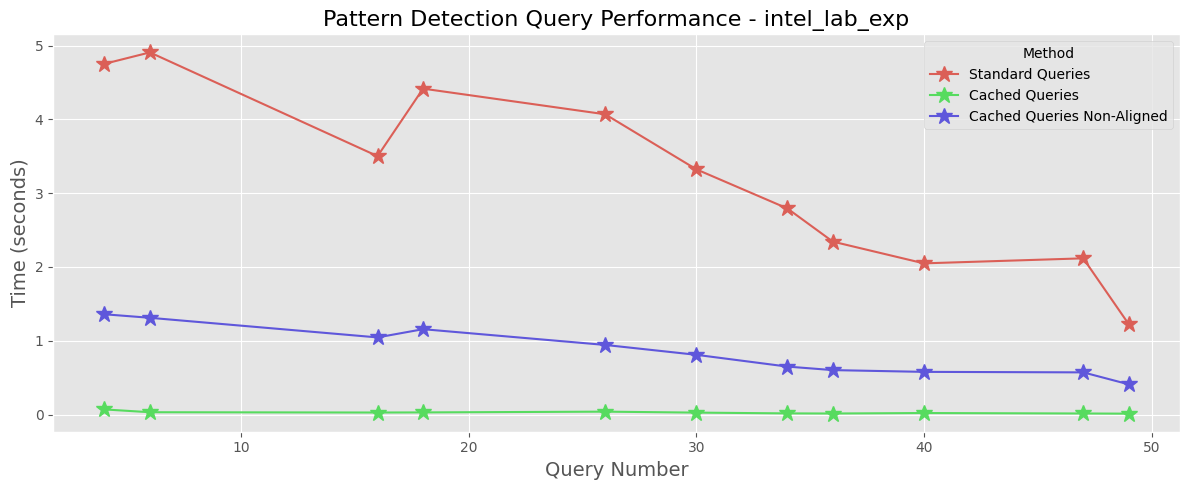

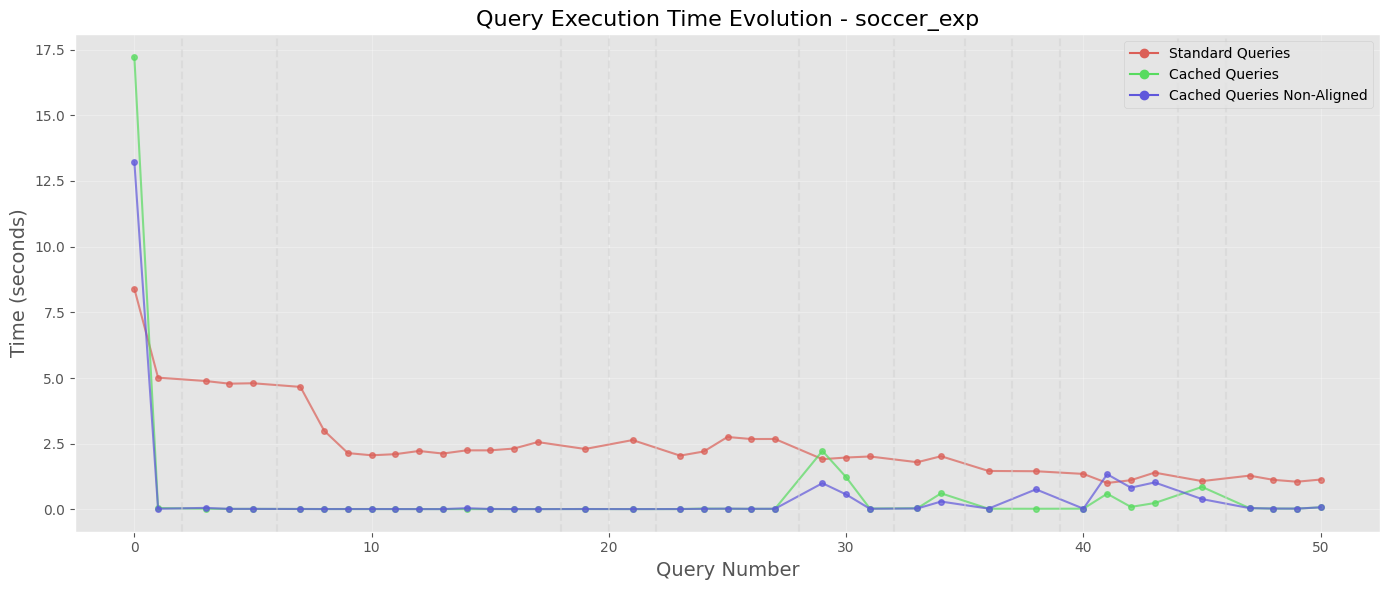

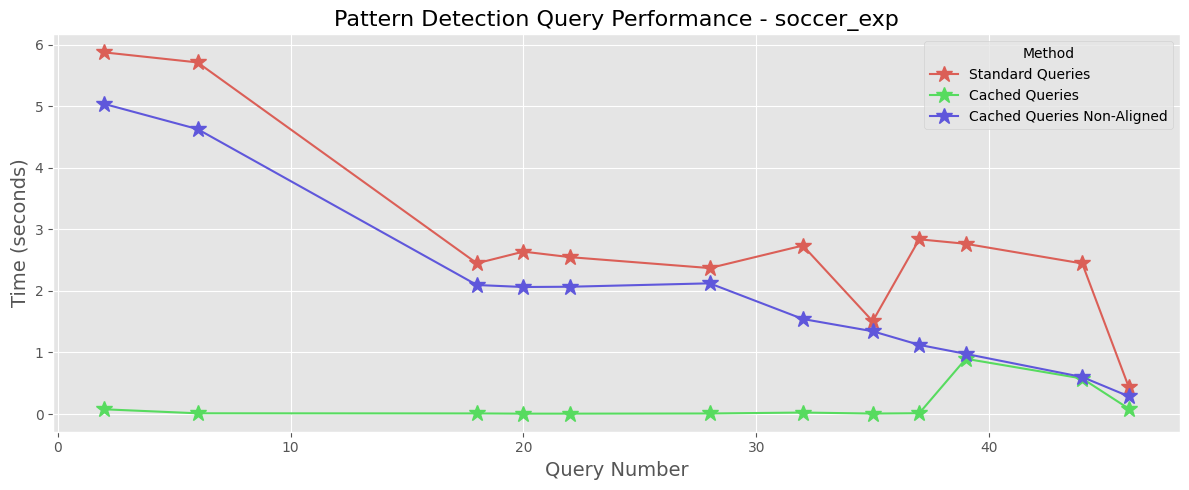

In [102]:
if all_combined is not None:
    # Plot time series for each dataset
    for dataset in all_datasets:
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            
            plt.figure(figsize=(14, 6))
            
            methods = dataset_df['method'].unique()
            
            # Define markers by operation type
            markers = {'Pattern Detection': '*', 'Other': 'o'}
            
            # Plot each method
            for i, method in enumerate(methods):
                method_data = dataset_df[dataset_df['method'] == method].sort_values('query #')
                
                # Split data into pattern detection and other operations
                pattern_data = method_data[method_data['operation'] == 'Pattern Detection']
                other_data = method_data[method_data['operation'] != 'Pattern Detection']
                
                # Color for this method
                color = METHOD_COLORS[i % len(METHOD_COLORS)]
                
                # Plot standard queries
                plt.plot(other_data['query #'], other_data['Time (sec)'], 
                        label=f"{method}" if i == 0 else "_nolegend_", 
                        marker=markers['Other'], markersize=4, alpha=0.7, 
                        color=color, linestyle='-')
            
            plt.title(f'Query Execution Time Evolution - {dataset}', fontsize=16)
            plt.xlabel('Query Number', fontsize=14)
            plt.ylabel('Time (seconds)', fontsize=14)
            
            # Create custom legend
            legend_elements = []
            for i, method in enumerate(methods):
                color = METHOD_COLORS[i % len(METHOD_COLORS)]
                legend_elements.append(plt.Line2D([0], [0], color=color, marker=markers['Other'], 
                                                 label=method, markersize=6, linestyle='-'))
            
            plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
            plt.grid(True, alpha=0.3)
            
            # Add a background highlighting for pattern detection queries
            for query_num in pattern_data['query #'].unique():
                plt.axvline(x=query_num, color='lightgray', linestyle='--', alpha=0.5)
            
            plt.tight_layout()
            plt.show()
            
            # Create a separate plot showing only pattern detection queries
            plt.figure(figsize=(12, 5))
            for i, method in enumerate(methods):
                method_data = dataset_df[dataset_df['method'] == method]
                pd_data = method_data[method_data['operation'] == 'Pattern Detection'].sort_values('query #')
                
                if not pd_data.empty:
                    plt.plot(pd_data['query #'], pd_data['Time (sec)'], 
                            label=method, marker='*', markersize=12, 
                            color=METHOD_COLORS[i % len(METHOD_COLORS)])
            
            plt.title(f'Pattern Detection Query Performance - {dataset}', fontsize=16)
            plt.xlabel('Query Number', fontsize=14)
            plt.ylabel('Time (seconds)', fontsize=14)
            plt.legend(title="Method")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
else:
    print("No data available for plotting time evolution.")

## Performance Distribution Analysis

Compare the distribution of query times between methods for each dataset.

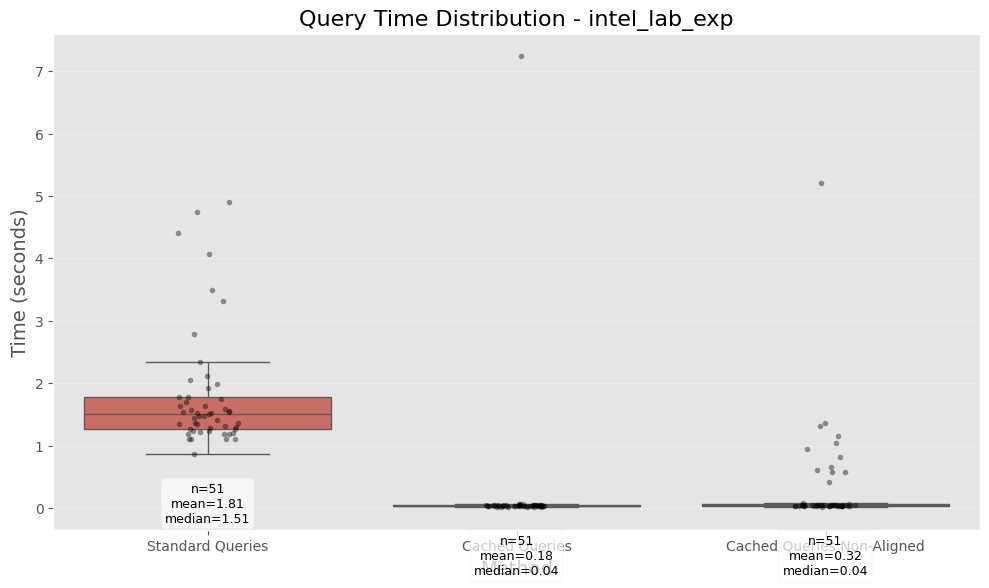

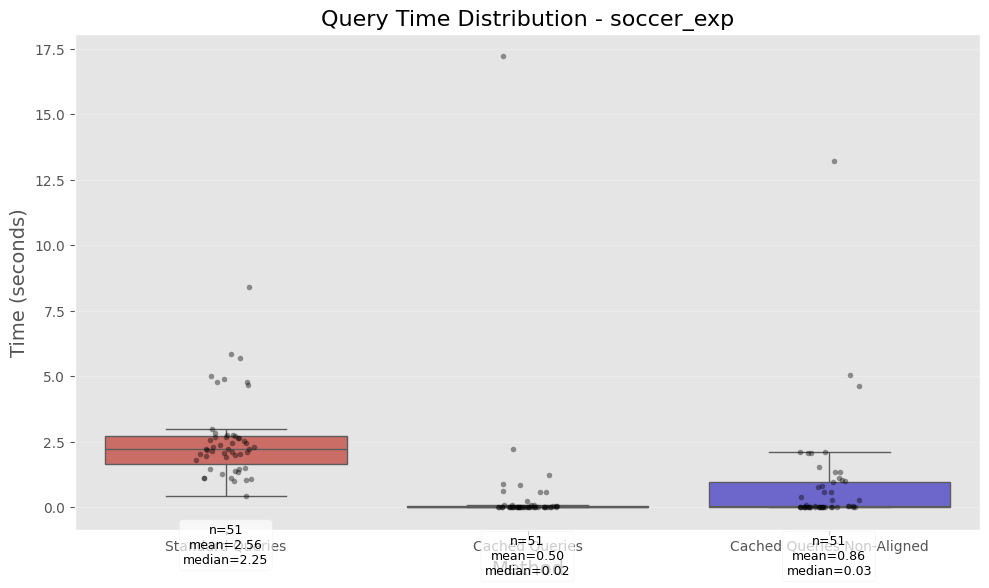



Overall Performance Statistics:


mean                                              \
method        Cached Queries Cached Queries Non-Aligned Standard Queries   
dataset                                                                    
intel_lab_exp       0.176275                   0.316081         1.808138   
soccer_exp          0.500012                   0.863452         2.555399   

                      median                                              \
method        Cached Queries Cached Queries Non-Aligned Standard Queries   
dataset                                                                    
intel_lab_exp       0.035976                   0.040257         1.511659   
soccer_exp          0.023021                   0.034434         2.246140   

                         min                                              \
method        Cached Queries Cached Queries Non-Aligned Standard Queries   
dataset                                                                    
intel_lab_exp        0.01173                   0.019912         0.859253   
soccer_exp           0.00633                   0.009884         0.437313   

                         max                                              \
method        Cached Queries Cached Queries Non-Aligned Standard Queries   
dataset                                                                    
intel_lab_exp       7.240554                   5.202895         4.907403   
soccer_exp         17.219380                  13.229312         8.397015   

                       count                                              
method        Cached Queries Cached Queries Non-Aligned Standard Queries  
dataset                                                                   
intel_lab_exp             51                         51               51  
soccer_exp                51                         51               51

In [103]:
if all_combined is not None:
    # Create boxplots for each dataset to compare distributions
    for dataset in all_datasets:
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            
            plt.figure(figsize=(10, 6))
            
            # Create boxplot
            sns.boxplot(x='method', y='Time (sec)', data=dataset_df, showfliers=False,
                       palette={m['name']: METHOD_COLORS[i] for i, m in enumerate(METHODS)})
            
            # Add strip plot on top to show individual points
            sns.stripplot(x='method', y='Time (sec)', data=dataset_df, 
                         size=4, color='black', alpha=0.4)
            
            # Calculate and add statistical summary
            for i, method in enumerate(dataset_df['method'].unique()):
                method_data = dataset_df[dataset_df['method'] == method]['Time (sec)']
                stats_text = (
                    f"n={len(method_data)}\n"
                    f"mean={method_data.mean():.2f}\n"
                    f"median={method_data.median():.2f}"
                )
                plt.annotate(
                    stats_text,
                    xy=(i, method_data.min()),
                    xytext=(0, -20),
                    textcoords="offset points",
                    ha='center',
                    va='top',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7)
                )
            
            plt.title(f'Query Time Distribution - {dataset}', fontsize=16)
            plt.xlabel('Method', fontsize=14)
            plt.ylabel('Time (seconds)', fontsize=14)
            plt.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # Overall summary table of performance statistics
    print("\n\nOverall Performance Statistics:")
    overall_stats = all_combined.pivot_table(
        index='dataset',
        columns='method',
        values='Time (sec)',
        aggfunc=['mean', 'median', 'min', 'max', 'count']
    )
    
    display(overall_stats)
else:
    print("No data available for distribution analysis.")